# Exponential Disc

In [1]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from pyDOE import lhs

sys.path.append('../')
from gpinn.network import FCN
from gpinn.training import TrainingPhase


As a reminder, the equation we want to solve is the following :

$$ \dfrac{1}{R'} \dfrac{\partial}{\partial R'} \left(R' \dfrac{\partial \Phi'}{\partial R'}\right) + \dfrac{1}{\eta^{2}}\dfrac{\partial^2 \Phi'}{\partial z'^2} = e^{-R'} \cosh^{-2}{z'}$$

where we have defined : $\phi'= \frac{\phi}{G M_d/z_d}$, $z' = \dfrac{z}{z_d}$, $R' = \dfrac{R}{R_d}$and $\eta = \frac{z_d}{R_d} $.

Therefore the residual would be written as follows:
$$\dfrac{1}{R'} \dfrac{\partial}{\partial R'} \left(R' \dfrac{\partial \Phi'}{\partial R'}\right) + \dfrac{1}{\eta^{2}}\dfrac{\partial^2 \Phi'}{\partial z'^2} - e^{-R_i'} \cosh^{-2}{z_i'}$$

and the loss function for the collocation points:
$$ \mathcal{L}_{\mathcal{F}}(\theta) = MSE_{\mathcal{F}} = \dfrac{1}{N_c}\sum_{i=1}^{N_c}\left\|\dfrac{1}{R'} \dfrac{\partial}{\partial R'} \left(R' \dfrac{\partial \Phi'}{\partial R'}\right) + \dfrac{1}{\eta^{2}}\dfrac{\partial^2 \Phi'}{\partial z'^2} - e^{-R_i'} \cosh^{-2}{z_i'}\right\|^2$$

$z_d$, for now, we will set it in order to have $\dfrac{z_d}{R_d}=0.2$

The domain where to solve the equations can be between $\dfrac{R}{R_d} = [0;20]$  and $\dfrac{z}{z_d} = [0;5]$

We should also investigate where and when is possible to solve the equation via approximations.

To compare our results, we set here :
- $R_d = 4$  
- $\dfrac{z_d}{R_d}=0.2$  
- $M_d = 10^{10.5}$   

In [2]:
def pde_residual(nn, x_pde):
    eta = 0.2
    r, z = x_pde[:, 0].unsqueeze(1), x_pde[:, 1].unsqueeze(1)
    x_pde.requires_grad = True 
    f = nn(x_pde)
    # -------- Differentiation w.r.t. R ----------------
    f_rz = torch.autograd.grad(f, x_pde, torch.ones(x_pde.shape[0], 1),retain_graph=True, create_graph=True)[0]
    f_r = f_rz[:, 0].unsqueeze(1)
    f_r = f_r * r
    f_rrz = torch.autograd.grad(f_r, x_pde, torch.ones(x_pde.shape[0], 1), retain_graph=True, create_graph=True)[0]
    f_rr = f_rrz[:, 0].unsqueeze(1)
    # -------- Differentiation w.r.t. z ----------------
    f_z = f_rz[:, 1].unsqueeze(1)
    f_zzr = torch.autograd.grad(f_z, x_pde, torch.ones(x_pde.shape[0], 1), retain_graph=True, create_graph=True)[0]
    f_zz = f_zzr[:, 1].unsqueeze(1)
    
    lhs = 1/r * f_rr + 1/eta**2 * f_zz
    rhs = torch.exp(r) * torch.cosh(z)**(-2)
    return lhs - rhs

In [3]:
def mse(residual: torch.Tensor):
    return residual.pow(2).mean()

def rmse(residual: torch.Tensor):
    return torch.sqrt(residual.pow(2).mean())

def mae(array: torch.Tensor):
    return torch.abs(array).mean()

## Parameters

In [4]:
steps = 10_000

layers = np.array([2, 32, 16, 1])

# To generate new data:
z_min = 0
z_max = 4
r_min = 0
r_max = 80
total_points_z = 150
total_points_r = 150
# Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
Nu = 50
Nf = 500

## Data Generation

In [5]:
z = torch.linspace(z_min, z_max, total_points_z).view(-1, 1)
r = torch.linspace(r_min, r_max, total_points_r).view(-1, 1)
# Create the mesh
R, Z = torch.meshgrid(r.squeeze(1), z.squeeze(1), indexing='xy')


**Note:** To evaluate the potential $\Phi(R, z)$ on the boundaries, we first need to interpolate it from the data acquired during previous simulations. 

In [6]:
from scipy.interpolate import RegularGridInterpolator

def load_data(reshape=True):
    data = np.loadtxt("test_phi_grid.dat")
    R_test, z_test, phi_test = data.T
    if reshape:
        return R_test.reshape(250, 250), z_test.reshape(250, 250), phi_test.reshape(250, 250)
    else:
        return R_test, z_test, phi_test
    
def phi_inter(R, z):
    _r, _z, _phi = load_data(reshape=True)
    f = RegularGridInterpolator((np.ascontiguousarray(_r[:, 0]), np.ascontiguousarray(_z[0, :])), np.ascontiguousarray(_phi))
    return torch.Tensor(f((R, z)))

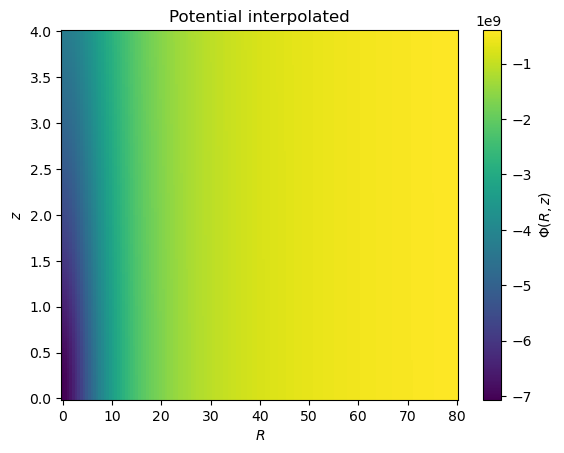

In [7]:
plt.figure()
plt.title('Potential interpolated')
plt.pcolormesh(R, Z, phi_inter(R, Z))
plt.xlabel("$R$")
plt.ylabel("$z$")
plt.colorbar(label="$\Phi(R, z)$");

## Boundary Conditions

### Left Boundary

Corresponds to $R'=0$ and $z' \in [0, 5]$.

In [8]:
left_X = torch.hstack((R[:, 0][:, None], Z[:, 0][:, None]))
left_Y = phi_inter(left_X[:, 0], Z[:, 0]).unsqueeze(1)

### Bottom Boundary 

Corresponds to $R'\in [0, 20]$ and $z' = 0$.

In [9]:
bottom_X = torch.hstack((R[0, :][:, None], Z[0, :][:, None]))
bottom_Y = phi_inter(bottom_X[:, 0], Z[0, :]).unsqueeze(1)

### Top Boundary

Corresponds to $R'\in [0, 20]$ and $z' = 5$.

In [10]:
# ------------------------- Upper Boundary -------------------------
top_X = torch.hstack((R[-1, :][:, None], Z[-1, :][:, None]))
top_Y = phi_inter(top_X[:, 0], Z[-1, :]).unsqueeze(1)

### Right Boundary

Corresponds to $R'=20$ and $z' \in [0, 5]$.

In [11]:
# ------------------------- Right Boundary -------------------------
right_X = torch.hstack((R[:, -1][:, None], Z[:, -1][:, None]))
right_Y = phi_inter(right_X[:, 0], Z[:, 0]).unsqueeze(1)

### Testing Data

In [12]:
# Transform the mesh into a 2-column vector
y_real = phi_inter(R, Z)
x_test = torch.hstack((R.transpose(1, 0).flatten()[:, None], Z.transpose(1, 0).flatten()[:, None]))
y_test = y_real.transpose(1, 0).flatten()[:, None]  # Colum major Flatten (so we transpose it)
# Domain bounds
lb = x_test[0]  # first value
ub = x_test[-1]  # last value

### Training Data

In [13]:
X_train = torch.vstack([left_X, bottom_X, top_X, right_X])
Y_train = torch.vstack([left_Y, bottom_Y, top_Y, right_Y])
# Choose(Nu) points of our available training data:
idx = np.random.choice(X_train.shape[0], Nu, replace=False)
X_train_Nu = X_train[idx, :]
Y_train_Nu = Y_train[idx, :]
# Collocation Points (Evaluate our PDe)


# Choose(Nf) points(Latin hypercube)
X_train_Nf = lb + (ub - lb) * lhs(2, Nf)  # 2 as the inputs are x and gamma
X_train_Nf = torch.vstack((X_train_Nf, X_train_Nu))  # Add the training points to the collocation point

### Initial Points

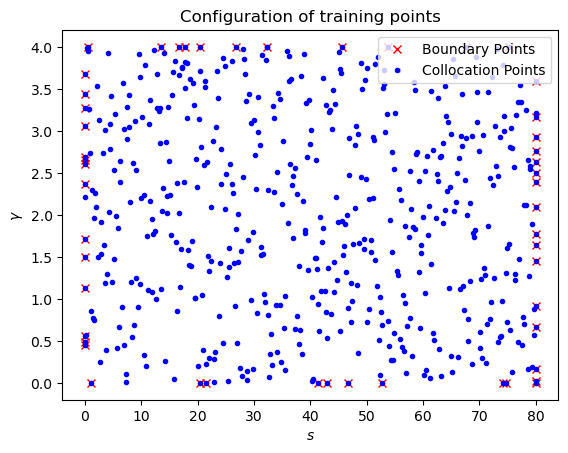

In [14]:
plt.figure()
plt.title("Configuration of training points")
plt.plot(X_train_Nu[:, 0], X_train_Nu[:, 1], 'xr', label="Boundary Points")
plt.plot(X_train_Nf[:, 0], X_train_Nf[:, 1], '.b', label="Collocation Points")
plt.xlabel('$s$')
plt.ylabel(r'$\gamma$')
plt.legend()
plt.show()
plt.close()

### Training

In [15]:
X_test = x_test.float()  # the input dataset (complete)
Y_test = y_test.float()  # the real solution

# Create Model
PINN = FCN(layers) #, act=torch.nn.SiLU())

print(PINN)

training = TrainingPhase(neural_net=PINN, training_points=(X_train_Nu, Y_train_Nu, X_train_Nf),
                         testing_points=(X_test, Y_test), equation=pde_residual, n_epochs=steps,
                         optimizer=torch.optim.Adam,
                         _loss_function=mse)

net, epochs, losses = training.train_model()

FCN(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


100%|████████████████████████████████████| 10000/10000 [00:13<00:00, 761.81it/s]


In [16]:
np.save("../arrays/loss_disc.npy", losses)
np.save("../arrays/epochs_disc.npy", epochs)
training.save_model("../models/exp_disc.pt")

### Comparing Results

In [17]:
R_test, z_test, phi_test = load_data()

In [18]:
Md = 10**(10.5)

In [25]:
input_matrix = np.array([R_test, z_test]).T
phi_ = PINN(input_matrix).detach().numpy().reshape(-1, 1)

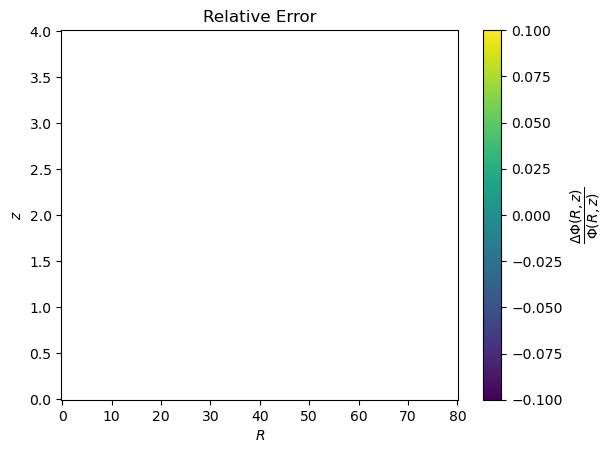

In [20]:
plt.figure()
plt.title("Relative Error")
plt.pcolormesh(R_test, z_test, np.abs(phi_test - phi_)/phi_)
plt.xlabel("$R$")
plt.ylabel("$z$")
plt.colorbar(label="$\dfrac{\Delta \Phi(R, z)}{\Phi(R, z)}$");

In [26]:
phi_

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)